# **Requirements**

In [ ]:
!pip3 install moviepy

In [ ]:
!pip3 install imageio==2.4.1

     ---------------------------------------- 3.3/3.3 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: imageio
    Found existing installation: imageio 2.22.2
    Uninstalling imageio-2.22.2:
      Successfully uninstalled imageio-2.22.2
  Running setup.py install for imageio: started
  Running setup.py install for imageio: finished with status 'done'


  DEPRECATION: imageio is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5, but you have imageio 2.4.1 which is incompatible.


In [ ]:
!pip3 install --upgrade imageio-ffmpeg

In [ ]:
pip install youtube-dl==2020.12.2

     ---------------------------------------- 1.8/1.8 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: youtube-dl
    Found existing installation: youtube-dl 2021.12.17
    Uninstalling youtube-dl-2021.12.17:
      Successfully uninstalled youtube-dl-2021.12.17
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
!pip3 install pafy moviepy

  Using cached imageio-2.22.2-py3-none-any.whl (3.4 MB)
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


***Remove comment tag of next cell for mounting drive to colab***

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In Single video_frame Classification, we apply image classifier on each video_frame of the video and classify action in each video_frame independently. This is the most fundamental approach which ignores the temporal relation of the video_frame sequence.  A jumping action, for instance, requires multiple video_frames in a video. Each video_frame is related to the one preceding it since all of the video_frames in that video depict jumping movement. But if we ignore this temporal relation and only find the action in only one video_frame then we might interpret that action as falling from above rather than jumping. So we can take an average of the probabilities of predictions and get a more robust final prediction.

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
import numpy as np

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
import os
os.chdir("D:\ML\Fahim\AIML_DATASET")

ALL CLASSES NAMES: 
BaseballPitch
Basketball
BasketballDunk
Bowling
BreastStroke
CricketBowling
CricketShot


RANDOM RANGE: 
[0, 1, 2, 3, 4, 5, 6]




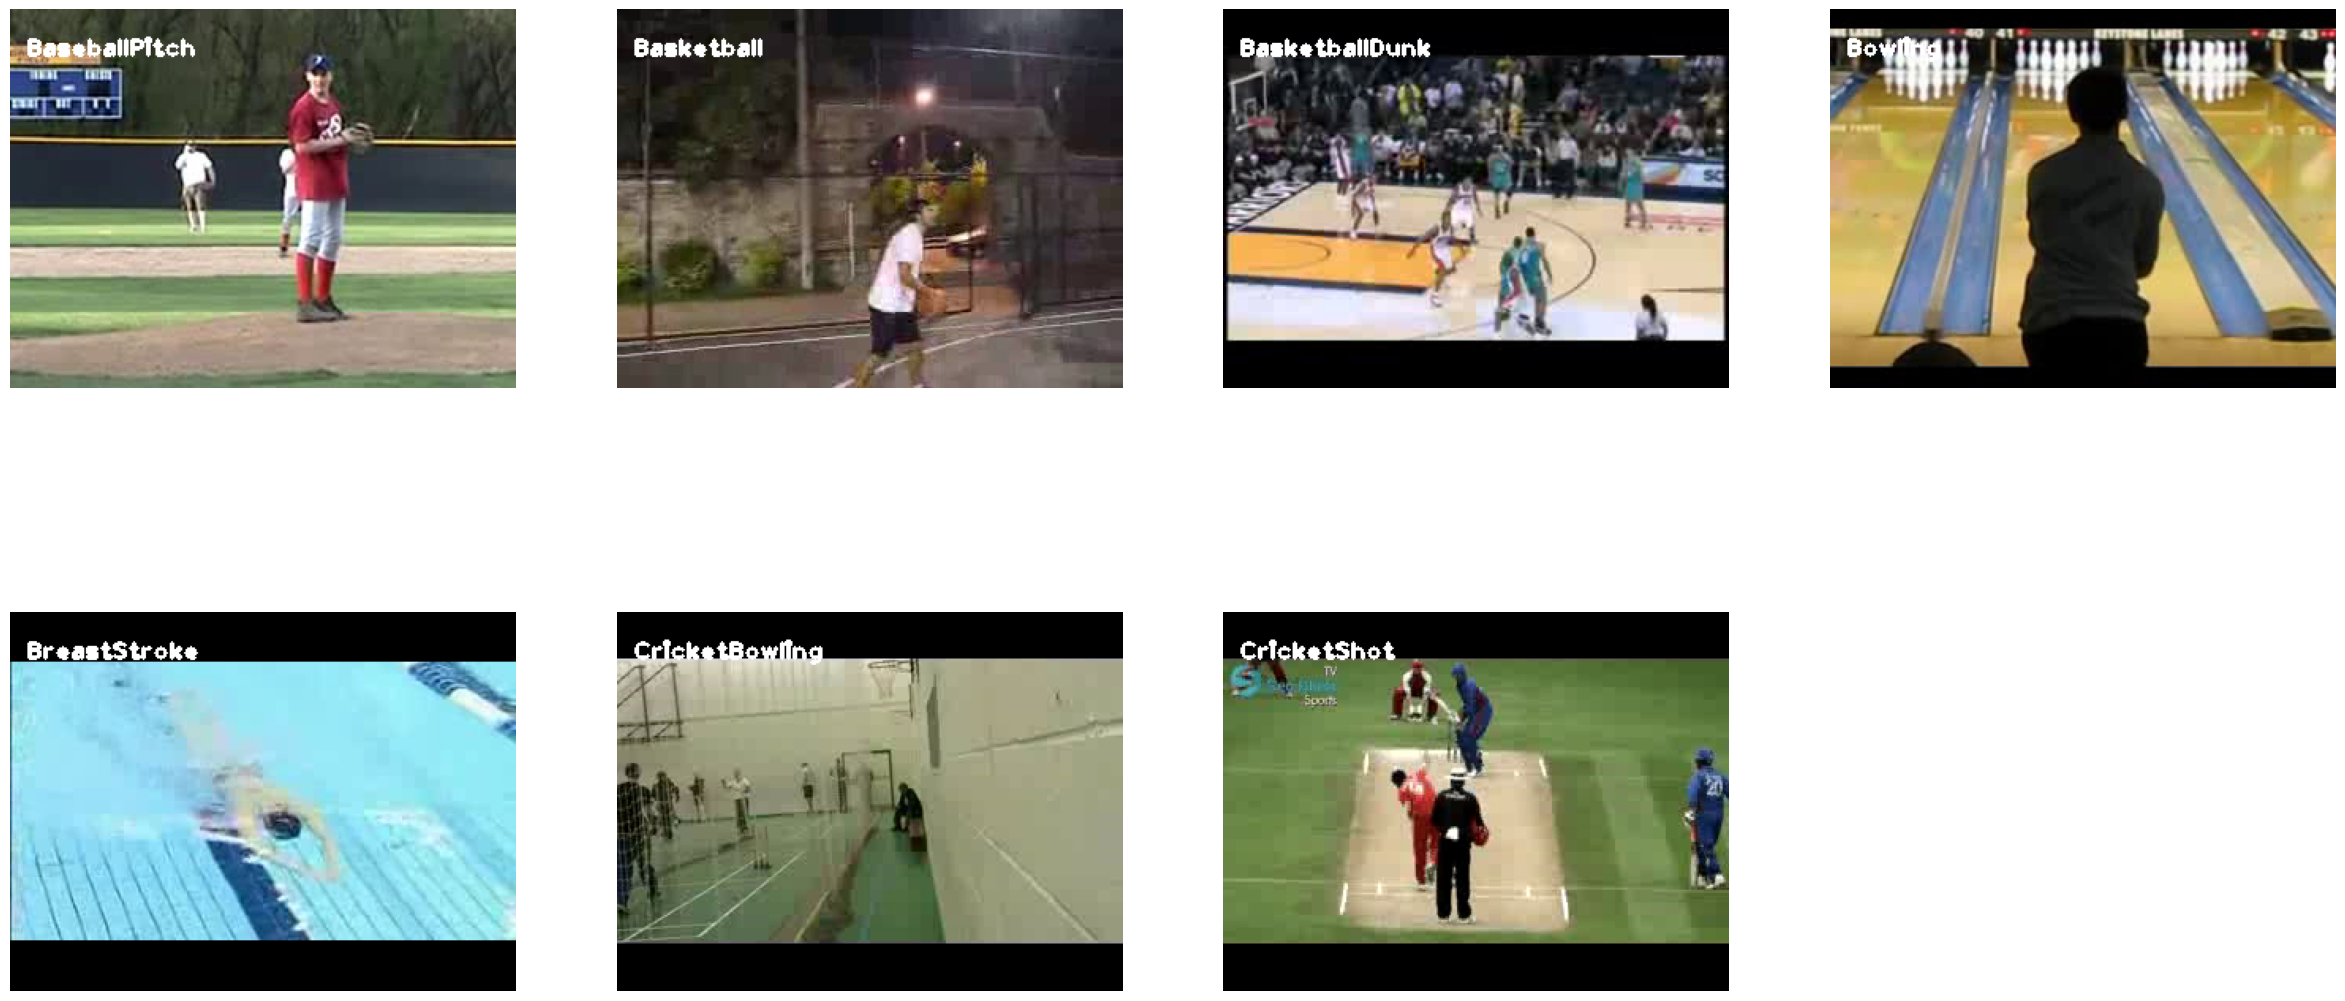

In [ ]:
plt.figure(figsize = (30, 30))

all_classes_names = os.listdir('D:\ML\Fahim\AIML_DATASET')

print("ALL CLASSES NAMES: ")
for i in all_classes_names:
  print(i)
print("\n")

dataset_class_range = [0,1,2,3,4,5,6]
print("RANDOM RANGE: ")
print(dataset_class_range)
print("\n")
for counter, random_index in enumerate(dataset_class_range, 1):


  class_name_index = all_classes_names[random_index]


  video_files_names_list = os.listdir(f'D:\ML\Fahim\AIML_DATASET\{class_name_index}')
  video_file_index = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'D:\ML\Fahim\AIML_DATASET\{class_name_index}/{video_file_index}')
  a, firstbgr_video_frame = video_reader.read()
  video_reader.release()
  rgb_video_frame = cv2.cvtColor(firstbgr_video_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_video_frame, class_name_index, (10, 30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
  plt.subplot(4, 4, counter);plt.imshow(rgb_video_frame);plt.axis('off')

**IMG_Height** and **IMG_Width** is the resized images size which we will feed in our network.

**Max_Num_of_Images_Per_Class** is the highest number of images used for training per class.

**classes_list** is the classes of videos used for training. We use 7 classes are as following : 
<ul>
  <li>CricketBowling</li>
  <li>CricketShot</li>
  <li>Basketball</li>
  <li>BasketballDunk</li>
  <li>BreastStroke</li>
  <li>BaseballPitch</li>
  <li>Bowling</li>
</ul> 



In [ ]:
IMG_Height , IMG_Width = 64, 64
Max_Num_of_Images_Per_Class = 3000
SEQUENCE_LENGTH = 20 
DATASET_DIR = "D:\ML\Fahim\AIML_DATASET"
classes_list = ["CricketBowling", "CricketShot","Basketball","BasketballDunk","BreastStroke","BaseballPitch","Bowling",]
model_output_size = len(classes_list)
dataset_dir = DATASET_DIR
dataset_directory = DATASET_DIR

# **Single Frame CNN**

For classifying videos, we have to extract frames from those videos, then pre-process those frames. This method takes a video path, then read that video file. Then we resize each frame according to our pre-defined height and weight. Then for reducing computatiional cost, we normalize each frame by 255. This function outputs a list containing frames of a video.

In [ ]:
def video_frames_extraction_single_CNN(video_path):
  video_frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  while True:
    success, video_frame = video_reader.read() 
    if not success:
      break
    resized_video_frame = cv2.resize(video_frame, (IMG_Height, IMG_Width))
    normalized_video_frame = resized_video_frame / 255
    video_frames_list.append(normalized_video_frame)

  video_reader.release()
  return video_frames_list

Now we will create our dataset for feed that to network. For this, we will loop through 50 number of videos from each category. For each video file of a certain class, we call previous frame extraction method. We will store these extracted frames of a certain class in a temporary list. Then from those frames, we randomly choose frames of number equal to Max_Num_of_Images_Per_Class. Then we add labels of each frame to label list. Each class index will be applied as label. For example, label 0 means class CricketBowling. 

In [ ]:
import math
def Create_Dataset_Single_CNN():
  temp_features = [] 
  features = []
  labels = []
  for class_index, class_name in enumerate(classes_list):
    print(f'Extracting Frame Data of Video Class: {class_name}')
    File_List = os.listdir(os.path.join(dataset_directory, class_name))
    i=0
    for file_name in File_List:

      if (i >= 50):
        break
      i=i+1
      video_file_path = os.path.join(dataset_directory, class_name, file_name)
      video_frames = video_frames_extraction_single_CNN(video_file_path)
      temp_features.extend(video_frames)
    
    features.extend(random.choices(temp_features, k=Max_Num_of_Images_Per_Class))
    labels.extend([class_index] * Max_Num_of_Images_Per_Class)
    # print("-------------> " , labels ,"  <--------------")
    temp_features.clear()

  features = np.asarray(features)
  labels = np.array(labels)  

  return features, labels

In [ ]:
features_dataset, labels_dataset = Create_Dataset_Single_CNN()

Extracting Frame Data of Video Class: CricketBowling
Extracting Frame Data of Video Class: CricketShot
Extracting Frame Data of Video Class: Basketball
Extracting Frame Data of Video Class: BasketballDunk
Extracting Frame Data of Video Class: BreastStroke
Extracting Frame Data of Video Class: BaseballPitch
Extracting Frame Data of Video Class: Bowling


In [ ]:
one_hot_encoded_labels = to_categorical(labels_dataset)

In [ ]:
features_data_train, features_data_test, labels_train, labels_test = train_test_split(features_dataset, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:
def create_model():
    model = Sequential()
 

    model.add(Conv2D(filters = 64, kernel_size = (4, 4), activation = 'relu', input_shape = (IMG_Height, IMG_Width, 3)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 64, kernel_size = (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))


    model.add(Conv2D(filters = 64, kernel_size = (4, 4), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    model.summary()
 
    return model
 
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        65600     
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 64)       2

In [ ]:
import time
start = time.time()

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

model_training_history = model.fit(x = features_data_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
end = time.time()
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

Epoch 1/50
3360/3360 [==============================] - 48s 14ms/step - loss: 0.6453 - accuracy: 0.7731 - val_loss: 0.2486 - val_accuracy: 0.9214
Epoch 2/50
3360/3360 [==============================] - 45s 14ms/step - loss: 0.2083 - accuracy: 0.9330 - val_loss: 0.2511 - val_accuracy: 0.9176
Epoch 3/50
3360/3360 [==============================] - 45s 13ms/step - loss: 0.1455 - accuracy: 0.9564 - val_loss: 0.0144 - val_accuracy: 0.9958
Epoch 4/50
3360/3360 [==============================] - 45s 13ms/step - loss: 0.0943 - accuracy: 0.9710 - val_loss: 0.0481 - val_accuracy: 0.9836
Epoch 5/50
3360/3360 [==============================] - 46s 14ms/step - loss: 0.0941 - accuracy: 0.9746 - val_loss: 0.0117 - val_accuracy: 0.9985
Epoch 6/50
3360/3360 [==============================] - 44s 13ms/step - loss: 0.0687 - accuracy: 0.9812 - val_loss: 0.0136 - val_accuracy: 0.9955
Epoch 7/50
3360/3360 [==============================] - 44s 13ms/step - loss: 0.0602 - accuracy: 0.9829 - val_loss: 0.0025 -

In [ ]:
model_evaluation_history = model.evaluate(features_data_test, labels_test)


132/132 [==============================] - 2s 17ms/step - loss: 0.0010 - accuracy: 1.0000


In [ ]:
import joblib
joblib.dump(model,  'D:\ML\Fahim\SINGLE_FRAME_CNN_1.pkl')   
 

INFO:tensorflow:Assets written to: ram://bd9cdcc5-4b84-4da0-a394-3170ddfd12c4/assets


INFO:tensorflow:Assets written to: ram://bd9cdcc5-4b84-4da0-a394-3170ddfd12c4/assets


['D:\\ML\\Fahim\\SINGLE_FRAME_CNN_1.pkl']

In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  metric_val_1 = model_training_history.history[metric_name_1]
  metric_val_2 = model_training_history.history[metric_name_2]
  epochs = range(len(metric_val_1))

  plt.plot(epochs, metric_val_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_val_2, 'red', label = metric_name_2)
   

  plt.title(str(plot_name))
 

  plt.legend()

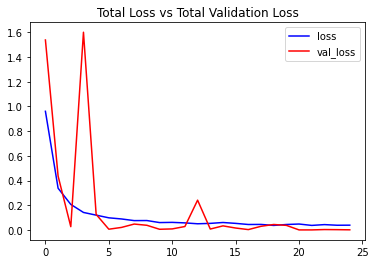

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

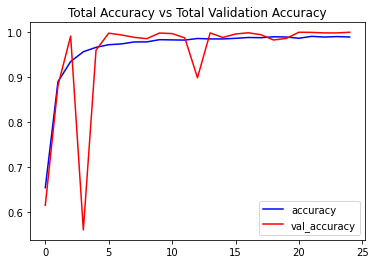

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **ConvLSTM**

In [ ]:
def frames_extraction(video_path):

  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) 
    success, frame = video_reader.read()
    if not success:
        break
    resized_frame = cv2.resize(frame, (IMG_Height, IMG_Width))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

In [ ]:
def create_dataset():
    
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        i=0
        for file_name in files_list:
            if (i >= 30):
              break
            i=i+1
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()


Extracting Data of Class: CricketBowling
Extracting Data of Class: CricketShot
Extracting Data of Class: Basketball
Extracting Data of Class: BasketballDunk
Extracting Data of Class: BreastStroke
Extracting Data of Class: BaseballPitch
Extracting Data of Class: Bowling


In [ ]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_data_train, features_data_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
features_data_train.shape


(157, 20, 64, 64, 3)

In [ ]:
def create_convlstm_model():

  model = Sequential()

  
  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                    IMG_Height, IMG_Width, 3)))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  
  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))


  
  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  
  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 20, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

  
  model.add(Flatten()) 
  
  model.add(Dense(len(classes_list), activation = "softmax"))
  
  
  model.summary()
  
  return model

In [ ]:
len(classes_list)

7

In [ ]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

In [ ]:
import time
start = time.time()

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 14, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x = features_data_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


end = time.time()
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

Epoch 1/50
32/32 [==============================] - 45s 1s/step - loss: 1.9554 - accuracy: 0.1200 - val_loss: 1.9453 - val_accuracy: 0.1250
Epoch 2/50
32/32 [==============================] - 32s 1s/step - loss: 1.9469 - accuracy: 0.1840 - val_loss: 1.9451 - val_accuracy: 0.1250
Epoch 3/50
32/32 [==============================] - 33s 1s/step - loss: 1.8740 - accuracy: 0.2000 - val_loss: 1.5993 - val_accuracy: 0.3125
Epoch 4/50
32/32 [==============================] - 33s 1s/step - loss: 1.6222 - accuracy: 0.2640 - val_loss: 1.7310 - val_accuracy: 0.3438
Epoch 5/50
32/32 [==============================] - 33s 1s/step - loss: 1.4304 - accuracy: 0.4480 - val_loss: 1.3794 - val_accuracy: 0.4062
Epoch 6/50
32/32 [==============================] - 34s 1s/step - loss: 1.1674 - accuracy: 0.5520 - val_loss: 1.4432 - val_accuracy: 0.3125
Epoch 7/50
32/32 [==============================] - 34s 1s/step - loss: 1.1113 - accuracy: 0.5680 - val_loss: 1.1345 - val_accuracy: 0.4688
Epoch 8/50
32/32 [==

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_data_test, labels_test)

2/2 [==============================] - 2s 479ms/step - loss: 0.5701 - accuracy: 0.7925


In [ ]:


model_file_name = f"D:\ML\Fahim\ConvLSTM_model_1.h5"
# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_val_1 = model_training_history.history[metric_name_1]
    metric_val_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_val_1))
    plt.plot(epochs, metric_val_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_val_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

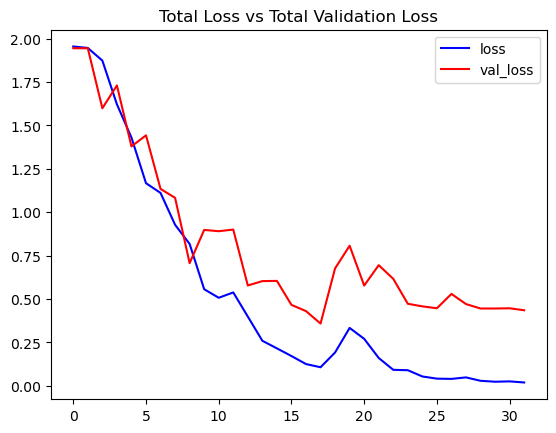

In [ ]:

plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

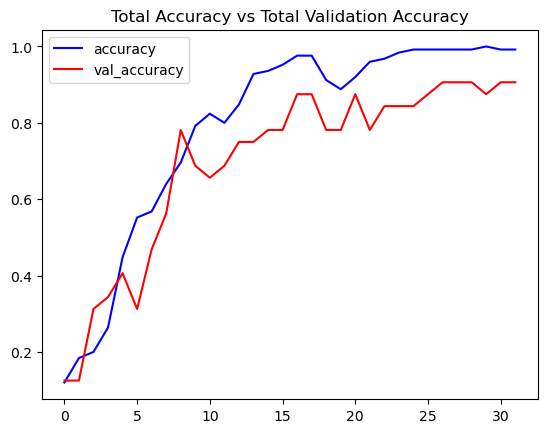

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

# **LRCN**

In [ ]:
def create_LRCN_model():

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMG_Height, IMG_Width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(classes_list), activation = 'softmax'))

    model.summary()

    return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 4, 4, 32)    

In [ ]:
import time
start = time.time()
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRCN_model_training_history = LRCN_model.fit(x = features_data_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
end = time.time()
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

Epoch 1/50
32/32 [==============================] - 4s 91ms/step - loss: 1.9092 - accuracy: 0.2320 - val_loss: 1.9016 - val_accuracy: 0.1875
Epoch 2/50
32/32 [==============================] - 2s 77ms/step - loss: 1.8825 - accuracy: 0.2480 - val_loss: 1.8581 - val_accuracy: 0.3438
Epoch 3/50
32/32 [==============================] - 2s 75ms/step - loss: 1.6529 - accuracy: 0.3360 - val_loss: 1.6011 - val_accuracy: 0.2812
Epoch 4/50
32/32 [==============================] - 2s 77ms/step - loss: 1.3357 - accuracy: 0.5360 - val_loss: 1.4376 - val_accuracy: 0.4375
Epoch 5/50
32/32 [==============================] - 2s 78ms/step - loss: 1.1179 - accuracy: 0.6000 - val_loss: 1.2901 - val_accuracy: 0.5312
Epoch 6/50
32/32 [==============================] - 3s 82ms/step - loss: 1.0585 - accuracy: 0.6560 - val_loss: 1.1443 - val_accuracy: 0.5938
Epoch 7/50
32/32 [==============================] - 2s 77ms/step - loss: 0.8401 - accuracy: 0.7920 - val_loss: 1.2244 - val_accuracy: 0.5000
Epoch 8/50
32

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_data_test, labels_test)

2/2 [==============================] - 0s 52ms/step - loss: 0.3016 - accuracy: 0.9434


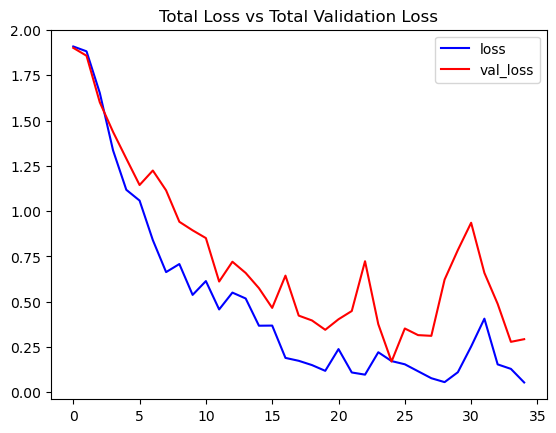

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

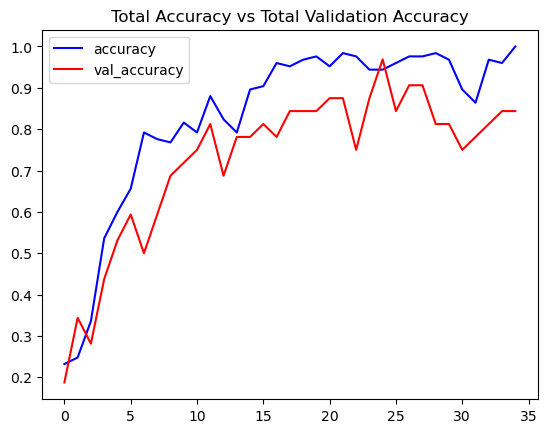

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')